In [1]:
# TODO
# Create buffer to ATL15_dh dataset so that variables outlines aren't found near grounding line

In [8]:
# Code to plot established active subglacial lakes and locate lake candidates
# using folium interactive plotting
#
# Written 2023-01-17 by W. Sauthoff (sauthoff@mines.edu)

# import internal packages
import os

# import external packages
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray

# define data and script directories dependent on home environment
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data_dir'
    SCRIPT_DIR = '/home/jovyan/script_dir'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'

# define utility functions
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereographic coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereographic
    to geodetic (lon, lat) coordinates
    
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

In [5]:
# Import ICESat-2 ATL15 Gridded Antarctic and Arctic Land Ice Height Change data product 
# https://doi.org/10.5067/ATLAS/ATL15.001
if os.getenv('HOME') == '/home/jovyan':
    # FIXME: Grab ATL15 data using earthaccess
    # s3url = 's3://nsidc-cumulus-prod-protected/ATLAS/ATL15/002/2019/ATL15_GL_0314_01km_002_01.nc'
    # FIXME: temporary workaround:
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
    granule = 's3://is2view/ATLAS/ATL15/002/2019/ATL15_AA_0314_01km_002_02.nc'
    group = 'delta_h'
    ATL15_dh = rioxarray.open_rasterio(granule, group=group, masked=True)
    # Display xarray data set metadata
    ATL15_dh

elif os.getenv('HOME') == '/Users/Wilson': 
    file = DATA_DIR + '/altimetry/ICESat2/ATL15.002-Ant/ATL15_AA_0314_01km_002_02.nc'
    ATL15_dh = rioxarray.open_rasterio(file, group='delta_h', masked=True)

# Add Title attribute
ATL15_dh.attrs['Title'] = 'IS2-ATL15-v2'

# Display xarray data set metadata
ATL15_dh

<xarray.Dataset>
Dimensions:              (y: 4461, x: 5461, time: 15)
Coordinates:
  * y                    (y) float64 2.27e+06 2.269e+06 ... -2.189e+06 -2.19e+06
  * x                    (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * time                 (time) float64 273.9 365.2 ... 1.461e+03 1.552e+03
    Polar_Stereographic  int64 0
Data variables:
    ice_area             (time, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/118)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    time_coverage_duration:             94150869.62631059
    time_coverage_end:                  2022-03-23T03:19:26.843657Z
    time_coverage_start:                2019-03-29T10:18:17.217346Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84
    Title:                              IS2-ATL15-v2

In [13]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013-boundaries/scripps_antarctica_polygons_v1.shp')
# Display geopandas geodataframe
Scripps_gl
# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [9]:
# import subglacial lake outlines 
outlines = open(SCRIPT_DIR + '/Smith2009_outlines.py')
read_file = outlines.read()
exec(read_file)

outlines = open(SCRIPT_DIR + '/SiegfriedFricker2018_outlines.py')
read_file = outlines.read()
exec(read_file)

In [10]:
# using geopandas example of polygon plotting with folium
# https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html
df = SiegfriedFricker2018_outlines
df.head()

,name,geometry,area (m^2),perimeter (m),cite
0,Bindschadler_1,"POLYGON ((-792264.327 -691480.857, -791281.458...",1.943146e+08,51147.562479,"Smith and others, 2009, J. Glac., doi:10.3189/..."
1,Bindschadler_2,"POLYGON ((-842788.063 -708464.240, -842354.948...",1.072249e+08,37249.152584,"Smith and others, 2009, J. Glac., doi:10.3189/..."
2,Bindschadler_3,"POLYGON ((-874893.221 -654533.044, -876415.673...",1.404559e+08,44183.483257,"Smith and others, 2009, J. Glac., doi:10.3189/..."
3,Bindschadler_4,"POLYGON ((-828821.778 -584874.415, -828822.032...",2.816411e+08,62680.016773,"Smith and others, 2009, J. Glac., doi:10.3189/..."
4,Bindschadler_5,"POLYGON ((-858067.460 -573467.564, -858714.391...",3.923966e+08,73686.203194,"Smith and others, 2009, J. Glac., doi:10.3189/..."


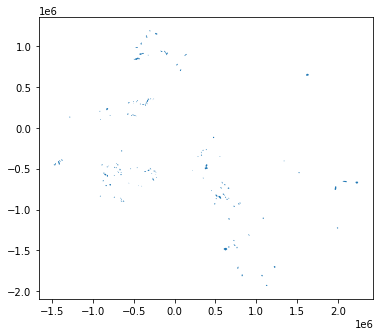

In [11]:
df.plot(figsize=(6, 6))
plt.show()

In [20]:
# clip ATL15 to some buffer inland of grounding line
Scripps_landice_buffer = Scripps_landice.geometry.buffer(-10000)

<AxesSubplot:>

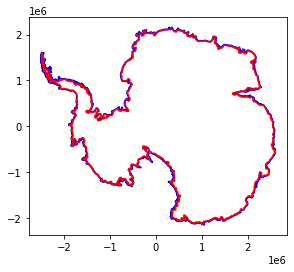

In [21]:
fig, ax = plt.subplots()
Scripps_landice.geometry.boundary.plot(ax=ax, ec='blue')
Scripps_landice_buffer.geometry.boundary.plot(ax=ax, ec='red')

In [22]:
# clip ATL15_dh to grounding line (first set crs)
#ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh_clipped = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)

In [23]:
# view crs
df.crs

<Derived Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
# Use WGS 84 (epsg:4326) as the geographic coordinate system
# because folium require coords in lon, lat
df = df.to_crs(epsg=4326)
print(df.crs)
df.head()

epsg:4326


,name,geometry,area (m^2),perimeter (m),cite
0,Bindschadler_1,"POLYGON ((-131.11415 -80.34358, -131.10497 -80...",1.943146e+08,51147.562479,"Smith and others, 2009, J. Glac., doi:10.3189/..."
1,Bindschadler_2,"POLYGON ((-130.05107 -79.89196, -129.96836 -79...",1.072249e+08,37249.152584,"Smith and others, 2009, J. Glac., doi:10.3189/..."
2,Bindschadler_3,"POLYGON ((-126.80123 -79.96843, -126.72681 -79...",1.404559e+08,44183.483257,"Smith and others, 2009, J. Glac., doi:10.3189/..."
3,Bindschadler_4,"POLYGON ((-125.20946 -80.68349, -125.11976 -80...",2.816411e+08,62680.016773,"Smith and others, 2009, J. Glac., doi:10.3189/..."
4,Bindschadler_5,"POLYGON ((-123.75578 -80.52208, -123.64847 -80...",3.923966e+08,73686.203194,"Smith and others, 2009, J. Glac., doi:10.3189/..."


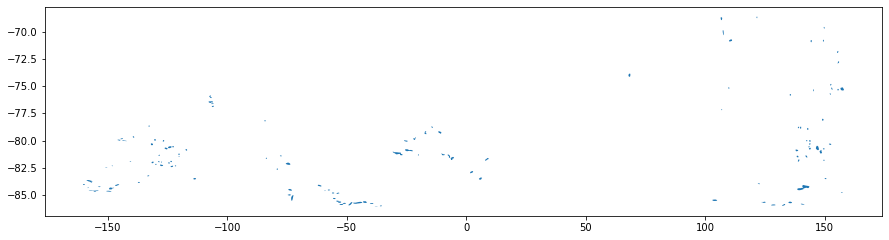

In [25]:
# plot polygons in new crs coords
df.plot(figsize=(15, 15))
plt.show()

In [26]:
m = folium.Map(location=[-77.5, 0], zoom_start=5, crs='EPSG3857', tiles='Stamen Terrain') # [lat, lon]
m

In [27]:
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'b'})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)
m

In [28]:
# add centroid markers
# Project to 3031 projected crs
df = df.to_crs(epsg=3031)

# Access the centroid attribute of each polygon
df['centroid'] = df.centroid

# project to WGS84 geographic crs
# geometry (active) column
df = df.to_crs(epsg=4326)

# Centroid column
df['centroid'] = df['centroid'].to_crs(epsg=4326)

In [29]:
for _, r in df.iterrows():
    lat = r['centroid'].y
    lon = r['centroid'].x
    folium.Marker(location=[lat, lon],
                  popup='name: {} <br> cite: {} <br> area (km^2): {} <br> perimeter (km): {}'.format(r['name'], r['cite'], r['area (m^2)']*1e-6, r['perimeter (m)']*1e-3)).add_to(m)

m

In [ ]:
# overlay variable outlines during ICESat-2 era using folium's ImageOverlay function

In [30]:
# Folium appears to not have polar projection, so trying GeoViews
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

gv.extension('bokeh', 'matplotlib')

ModuleNotFoundError: No module named 'geoviews'

In [50]:
gv.Polygons(SiegfriedFricker2018_outlines)
#   , vdims=['pop_est', ('name', 'Country')]).opts(
#     tools=['hover'], width=600, projection=crs.Robinson()
# )

/srv/conda/envs/notebook/lib/python3.10/site-packages/geoviews/operation/projection.py:99: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if proj_geom.geom_type == 'GeometryCollection' and len(proj_geom) == 0:
/srv/conda/envs/notebook/lib/python3.10/site-packages/geoviews/operation/projection.py:79: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polys = [g for g in geom if g.area > 1e-15]


:Polygons   [Longitude,Latitude]   (name,area (m^2),perimeter (m),cite)

In [51]:
gv.Polygons(gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')), vdims=['pop_est', ('name', 'Country')]).opts(
    tools=['hover'], width=600, projection=crs.SouthPolarStereo()
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/geoviews/operation/projection.py:79: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polys = [g for g in geom if g.area > 1e-15]
/srv/conda/envs/notebook/lib/python3.10/site-packages/geoviews/operation/projection.py:99: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if proj_geom.geom_type == 'GeometryCollection' and len(proj_geom) == 0:


:Polygons   [Longitude,Latitude]   (pop_est,name)

In [31]:
pd.read_parquet(DATA_DIR + 'altimetry/icesat/icesat_trackmap.parquet')

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.